<a href="https://colab.research.google.com/github/yash2029/Image-Indexing/blob/master/Project_Final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 186 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

import fastai
from fastai import *
from fastai.vision import *
from fastai.imports import *

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.data import ImageDataLoaders
from fastai.vision.learner import cnn_learner
from fastai.vision.all import *

from fastai.metrics import accuracy_multi
from fastai.metrics import APScoreMulti

from torchvision.models import resnet34
fastai.__version__

'2.5.2'

In [4]:
!wget https://www.dropbox.com/s/so5bw0s1det62qe/multilabel.csv
!wget https://www.dropbox.com/s/laxpf4edui4vbtj/images.rar
!unrar x "images.rar" "/content/"

--2021-09-22 16:02:32--  https://www.dropbox.com/s/so5bw0s1det62qe/multilabel.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/so5bw0s1det62qe/multilabel.csv [following]
--2021-09-22 16:02:32--  https://www.dropbox.com/s/raw/so5bw0s1det62qe/multilabel.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc78e16a7fbc0c8f16d12445b4e9.dl.dropboxusercontent.com/cd/0/inline/BWrsloHd4ijRfDnBzJqoI2sle750RC-AHkQRBqgP3jgmWtwNW1sAbVxe8XL1fEbegkk6Zj7kblhYdZIzS3PxCV4bdKcXXoQiU6-m1G4qvunb032l_WNDHzrw0GhN_WDOfD6WyK-zt4xoB0BEqFOwEfwr/file# [following]
--2021-09-22 16:02:32--  https://uc78e16a7fbc0c8f16d12445b4e9.dl.dropboxusercontent.com/cd/0/inline/BWrsloHd4ijRfDnBzJqoI2sle750RC-AHkQRBqgP3jgmWtwNW1sAbVxe8XL1fEbegkk6Zj7kblhYdZIzS3Px

In [5]:
!ls

images	images.rar  multilabel.csv  sample_data


In [6]:
df = pd.read_csv("multilabel.csv")
df.head()

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car
0,1,1,1,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0
3,4,1,1,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0


In [7]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)
class_count

,class,Count
1,impervious,3133
2,water,998
3,clutter,1891
4,vegetation,1086
5,building,1001
6,tree,258
7,boat,270
8,car,705


In [8]:
classes = list(class_count['class'])
df = pd.read_csv("multilabel.csv")
df1 = pd.DataFrame({"image_name":[],
                         "tags":[]})

for i in range(len(df)):
  tag_str = ""
  for j in range(0,8):
    if df.at[i,classes[j]] == 1:
      tag_str = tag_str + ' ' + classes[j]
  tag_str = tag_str.strip()  
  df1 = df1.append({"image_name": str(df.at[i,'image\label']) + '.png', "tags": tag_str}, ignore_index=True)
  
df1.head()

,image_name,tags
0,1.png,impervious water
1,2.png,impervious water
2,3.png,impervious water
3,4.png,impervious water
4,5.png,impervious water


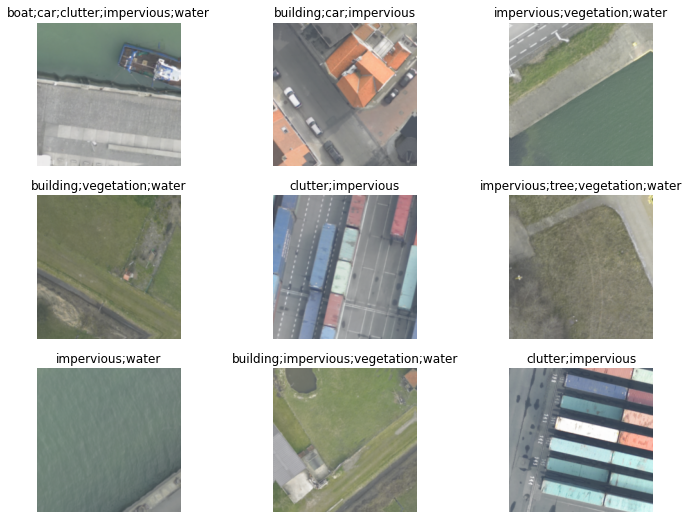

In [9]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'/content/images/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.)),
                   batch_tfms = batch_tfms)
dls = planet.dataloaders(df1)
dls.show_batch(max_n=9, figsize=(12,9))

In [10]:
resnet = cnn_learner(dls, models.resnet34, metrics=[accuracy_multi, APScoreMulti()])
squeezenet = cnn_learner(dls, models.squeezenet1_0, metrics=[accuracy_multi, APScoreMulti()])
densenet = cnn_learner(dls, models.densenet121, metrics=[accuracy_multi, APScoreMulti()])
vgg16 = cnn_learner(dls, models.vgg16_bn, metrics=[accuracy_multi, APScoreMulti()])
alex = cnn_learner(dls, models.alexnet, metrics=[accuracy_multi, APScoreMulti()])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [11]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

resnet.loss_func = BCEWithLogitsLossFlat()
squeezenet.loss_func = BCEWithLogitsLossFlat()
densenet.loss_func = BCEWithLogitsLossFlat()
vgg16.loss_func = BCEWithLogitsLossFlat()
alex.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.0012022644514217973)

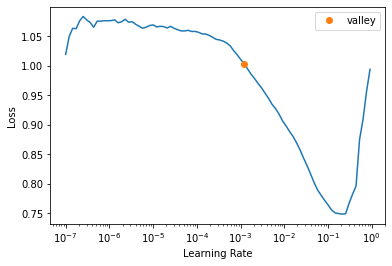

In [12]:
resnet.lr_find()

In [13]:
lr = 1e-2
resnet = resnet.to_fp16()
resnet.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.603491,0.273156,0.906811,0.881451,01:01
1,0.349744,0.191711,0.926085,0.897081,01:03
2,0.251804,0.157314,0.935816,0.922686,01:01
3,0.202162,0.145538,0.941617,0.931311,01:02
4,0.172084,0.143670,0.942552,0.932312,01:03


SuggestedLRs(valley=0.002511886414140463)

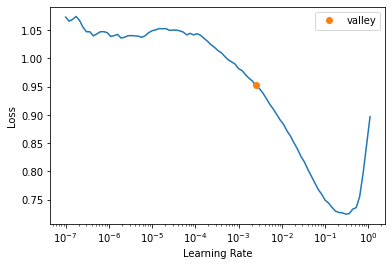

In [14]:
squeezenet.lr_find()

In [15]:
lr = 1e-2
squeezenet = squeezenet.to_fp16()
squeezenet.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.565301,0.247517,0.913548,0.876415,00:58
1,0.348342,0.196232,0.923466,0.894030,00:57
2,0.262962,0.158922,0.934880,0.928242,00:57
3,0.214519,0.150875,0.938810,0.928776,00:57
4,0.184665,0.147872,0.940681,0.931970,00:57


SuggestedLRs(valley=0.0010000000474974513)

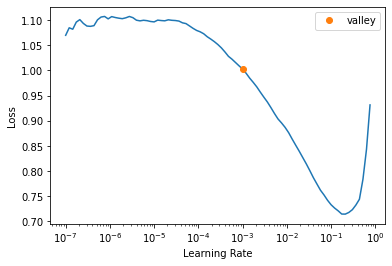

In [16]:
densenet.lr_find()

In [17]:
lr = 1e-2
densenet = densenet.to_fp16()
densenet.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.540983,0.225921,0.917665,0.883192,01:17
1,0.308591,0.161331,0.935816,0.928377,01:10
2,0.217580,0.142515,0.942178,0.939028,01:11
3,0.166647,0.128526,0.947979,0.949657,01:10
4,0.136197,0.121881,0.948540,0.951424,01:10


SuggestedLRs(valley=0.0005754399462603033)

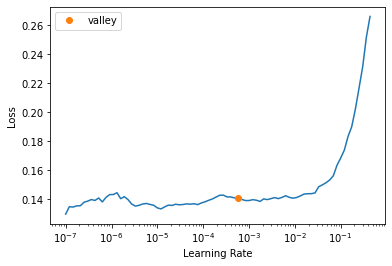

In [19]:
vgg16.lr_find()

In [18]:
lr = 1e-2
vgg16 = vgg16.to_fp16()
vgg16.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.586343,0.253262,0.913361,0.890353,01:29
1,0.339841,0.178386,0.931699,0.902873,01:16
2,0.246377,0.155230,0.938623,0.927351,01:15
3,0.195472,0.135627,0.945546,0.939030,01:15
4,0.165530,0.133348,0.946669,0.940144,01:16


SuggestedLRs(valley=0.0008317637839354575)

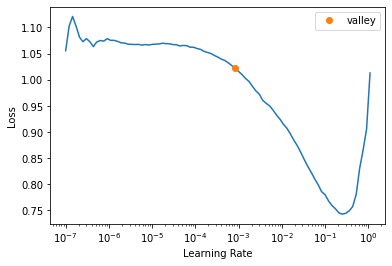

In [20]:
alex.lr_find()

In [21]:
lr = 1e-2
alex = alex.to_fp16()
alex.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,time
0,0.605138,0.268922,0.904753,0.833282,00:56
1,0.368040,0.224922,0.909805,0.866159,00:55
2,0.279460,0.190319,0.922717,0.883658,00:56
3,0.231905,0.171625,0.927582,0.907375,00:55
4,0.205608,0.169960,0.928518,0.903983,00:55


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
model_save1 = 'Resnet_DS2.pt'
path1 = Path(F"/content/gdrive/My Drive/{model_save1}")
resnet.export(path1)

model_save2 = 'Squeezenet_DS2.pt'
path2 = Path(F"/content/gdrive/My Drive/{model_save2}")
squeezenet.export(path2)

model_save3 = 'Densenet_DS2.pt'
path3 = Path(F"/content/gdrive/My Drive/{model_save3}")
densenet.export(path3)

model_save4 = 'Vgg16_DS2.pt'
path4 = Path(F"/content/gdrive/My Drive/{model_save4}")
vgg16.export(path4)

model_save5 = 'Alexnet_DS2.pt'
path5 = Path(F"/content/gdrive/My Drive/{model_save5}")
alex.export(path5)

!ls /content/gdrive/My\ Drive

 2.jpg		 'Colab Notebooks'   Squeezenet_DS2.pt
 Alexnet_DS2.pt   Densenet_DS2.pt    Vgg16_DS2.pt
 Classroom	  Resnet_DS2.pt      YashThapliyal_180911110_IT.pdf
